In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension, model_training
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [5]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
# mixed_volumetric_dataset_term = pd.read_csv(
#     preprocessed_dataset_path +
#     'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [6]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
df = european_volumetric_dataset_term.copy()
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
df = data_exploration.MassUnivariate.remove_outliers(df,
                                                    col=dependentVar,
                                                     threshold=3,
                                                    remove_schemes='percentage',
                                                    percentage_of_outlier=0.1)
df = df.rename(columns = {'AAL 93':'AAL 109'})

In [7]:
# imputed_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_ASD_AllLDimputed')

PRS_ASD_EuroLD=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_Euro_LD')
# PRS_SCZ_EuroLD = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_SCZ_Euro_LD')
# PRS_ASD_EuroLD_imputed=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_EuroLDimputed')

df = df.rename(columns={i:i+'_ASD_All_LD' for i in df.columns if 'PRS' in i})

# df = df.merge(imputed_PRS,left_on='ID',right_on=imputed_PRS.index)
df = df.merge(PRS_ASD_EuroLD,left_on='ID',right_on=PRS_ASD_EuroLD.index)
# df = df.merge(PRS_SCZ_EuroLD,left_on='ID',right_on=PRS_SCZ_EuroLD.index)


# df = df.merge(PRS_ASD_EuroLD_imputed,left_on='ID',right_on=PRS_ASD_EuroLD_imputed.index)

In [8]:
df.shape

(205, 4531)

In [9]:
# # plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams["axes.grid.axis"] ="y"
# sns.set_style('whitegrid')
# g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
# g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
# g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
# g.set_ylabels('Number of subjects',fontsize=15)
# g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
# g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
# g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
# g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


# g.axes[0][0].set_title('cohort = European',size=15)
# g.axes[0][1].set_title('cohort = Asian',size=15)
# plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
# sns.despine(bottom=True,left=True)
# # g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [10]:
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
dependentVar = [i for i in df.columns if bool(re.search('AAL \d',i))]
prs = [i for i in df.columns if 'Euro' in i]

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
from sklearn.decomposition import PCA

In [12]:
_,independentVar = data_exploration.MassUnivariate.prepare_data(df = df,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                                                          dependentVar_cols=prs)
independentVar = independentVar.drop(columns='const')

In [22]:
pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA(n_components=.8),
                ('lin_Reg',LinearRegression()))])

In [36]:
pipe = Pipeline([('scaler',StandardScaler()),
#                  ('adjusting_scaler',model_training.AdjustingScaler(cat_independentVar_idx=['Gender_2.0'],
#                                                                    cont_independentVar_idx=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
#                               list_of_vars=independentVar.columns.to_list())),
                 ('pca',PCA(n_components=.8)),
                ('lin_Reg',LinearRegression())])

In [37]:
model_summary = model_training.NestedCV.perform_nestedcv(
    pipe,df = df,bins=2,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                          dependentVar_cols=prs,n_splits=3,scoring='r2')

In [38]:
pd.DataFrame({i:[model_summary[i][split]['test_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,-0.119906,-0.044349,-0.041050
PRS_1e-07_ASD_Euro_LD,-0.022294,0.104467,-0.029636
PRS_1e-06_ASD_Euro_LD,-0.163731,0.056181,0.044734
PRS_1e-05_ASD_Euro_LD,0.008168,0.046737,-0.053647
PRS_0.0001_ASD_Euro_LD,-0.040963,-0.003506,-0.044709
PRS_0.001_ASD_Euro_LD,0.004929,0.051730,-0.058542
PRS_0.01_ASD_Euro_LD,0.065272,0.012454,0.084953
PRS_0.05_ASD_Euro_LD,0.067246,-0.057791,-0.085982
PRS_0.1_ASD_Euro_LD,0.068187,-0.064038,-0.222787
PRS_0.5_ASD_Euro_LD,0.039435,-0.118278,-0.147749


In [ ]:
lin_reg

In [101]:
pd.DataFrame({i:[model_summary[i][split]['cv_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,"[0.020470588159416603, -0.030608108131903622, ...","[0.0035446024944549848, -0.03205312493637047, ...","[-0.0933690340822182, 0.021245454512250905, -0..."
PRS_1e-07_ASD_Euro_LD,"[0.028622948109082613, -0.11943668589158052, -...","[0.08869516524974885, 0.033538265270392054, -0...","[-0.1969097433667275, 0.12649983344128812, 0.0..."
PRS_1e-06_ASD_Euro_LD,"[-0.021763730344513066, -0.17889472312135668, ...","[-0.03485112592143613, 0.017695333549868297, -...","[-0.14582677552988166, 0.015913836765960254, -..."
PRS_1e-05_ASD_Euro_LD,"[-0.009747745672150199, -0.04758339578897641, ...","[0.06831726508310632, -0.015003485302910402, -...","[0.0646333089211042, 0.1115732199981182, -0.04..."
PRS_0.0001_ASD_Euro_LD,"[0.09368072487900514, 0.002127412801282369, -0...","[0.1684213043381918, -0.002749219741268183, -0...","[-0.2031405275681526, -0.04403843196028623, 0...."
PRS_0.001_ASD_Euro_LD,"[-0.09429761555810168, 0.07971829508553163, -0...","[-0.13350516026505566, -0.05526365805027744, -...","[-0.005012461888782349, 0.01791844643788132, -..."
PRS_0.01_ASD_Euro_LD,"[-0.06081412484963322, 0.017845013759780537, 0...","[0.020432791360621705, 0.0757909214228285, 0.0...","[-0.021906400602517584, -0.038764601825013845,..."
PRS_0.05_ASD_Euro_LD,"[0.03310251333810721, -0.004245412567063456, -...","[0.03748706675055047, 0.03864127283238905, 0.0...","[-0.17642315882763682, -0.1361204049885092, 0...."
PRS_0.1_ASD_Euro_LD,"[-0.061234689842185164, -0.17364594983998272, ...","[0.05087274736022296, 0.022822956908664427, -0...","[-0.09858408655429107, 0.05522984993080826, 0...."
PRS_0.5_ASD_Euro_LD,"[-0.15386737625798852, -0.1626773873861802, 0....","[-0.022357712837534294, 0.02508059562831022, -...","[0.0444335624837503, -0.12138032232283424, -0...."


In [110]:
prs_ = 'PRS_0.01_ASD_Euro_LD'
y_test_pred_dict = {i:{'y_pred':model_summary[prs_][i]['y_pred'],
   'y_test':model_summary[prs_][i]['y_test'],'split':[i for n in range(len(model_summary[prs_][i]['y_test']))]} for i in model_summary[prs_].keys()}

In [111]:
y_test_pred_dict = pd.concat([pd.DataFrame(y_test_pred_dict[i]) for i in y_test_pred_dict.keys()])

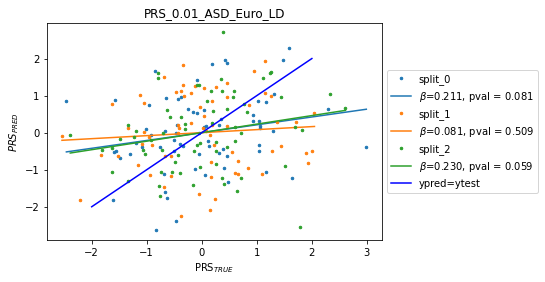

In [112]:
ax = visualisation.plot_Linear_Reg(data = y_test_pred_dict, x = 'y_test', y = 'y_pred',markersize=5,scaling='both',hue='split',hide_CI=True,xlabel=r'PRS$_{TRUE}$',ylabel=r'$PRS_{PRED}$',title=f'{prs_}')
ax.plot([-2,2],[-2,2],'b-',label='ypred=ytest')
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

In [104]:
lin_reg = LinearRegression()

In [72]:
y,X = data_exploration.MassUnivariate.prepare_data(df = df,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                                  dependentVar_cols=prs)

,const,GA_vol,PMA_vol,17 ICV (all except bone),euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3,AAL 1,AAL 2,AAL 3,...,AAL 85,AAL 86,AAL 87,AAL 88,AAL 89,AAL 90,AAL 91,AAL 92,AAL 109,Gender_2.0
0,1.0,-0.867947,0.308270,1.838078,0.707933,0.072990,0.254428,1.037355,0.720263,1.954052,...,1.494046,2.006972,1.142841,1.242644,1.554399,1.874374,1.161712,1.020085,0.765372,0
1,1.0,-0.296195,0.308270,0.785095,-1.895899,0.408387,-2.257130,1.201847,0.931634,1.279001,...,0.124951,0.326012,0.776416,-0.109148,0.737017,0.062129,0.499356,0.639860,0.064510,0
2,1.0,-0.867947,0.811151,0.894440,-2.378463,-2.017302,-0.191470,1.129626,1.306049,0.556969,...,0.305463,1.077255,2.002414,1.625938,0.837295,0.612762,1.318961,0.958324,2.131004,0
3,1.0,1.190359,0.811151,1.607367,0.696581,0.640625,-1.137209,1.746550,1.301531,1.158332,...,1.690517,1.031688,0.422968,0.433344,1.595844,1.629106,1.593206,1.246643,1.860469,0
4,1.0,1.533410,1.062591,1.384905,1.023702,-0.120918,-0.394134,1.703406,0.999604,1.326147,...,1.333297,0.827409,-0.571724,-0.073647,0.949096,0.924231,0.928284,0.800947,1.262021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.504257,-0.278424,-0.785043,0.314708,0.218152,1.565692,-0.812053,-0.615507,-0.895339,...,-0.565591,-0.778999,-0.858757,0.011776,-0.364415,-0.862511,-0.765616,-0.708282,-0.418876,0
201,1.0,1.419060,0.308270,-0.177393,0.893955,-0.578483,0.056851,-0.556549,-0.386908,-0.229354,...,0.386582,0.208916,-0.449582,-0.822486,-0.300125,-0.314727,0.269697,0.363599,0.225227,1
202,1.0,-1.897100,0.643524,0.018181,0.711032,-0.018205,0.894654,0.160938,0.394489,-0.327604,...,-0.548970,0.320820,-0.406069,0.001237,0.430929,-0.194806,-0.148887,0.172752,-0.037288,1
203,1.0,0.847308,0.643524,0.690544,0.130952,-1.068898,0.989428,0.633420,1.031961,0.811328,...,0.791183,0.764715,0.519155,0.432789,0.680005,0.534352,0.864534,1.091121,0.679923,1
